# Title
Written by: 
- Mikayla Liang
- Cici Liu
- Riley McNair
- Hao Wen

## 1. Introduction

## 2. Methods and Results

###  Exploratory Data Analysis (EDA)

In [1]:
set.seed(123)

# install.packages("GGally")
# install.packages("leaps")

library(tidyverse)
library(GGally)
library(reshape2)
library(glmnet)
library(tidymodels)
library(jsonlite)
library(repr)
library(leaps)

options(repr.plot.width=6, repr.plot.height=5)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.3     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2


Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths


Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Loaded glmnet 4.1-8

── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.

In [2]:
raw_data <- read.csv("https://github.com/ciciliujx/Univeristy-Ranking/raw/main/data/World%20University%20Rankings%202023.csv", na.strings = c("NaN", "n/a", ""))

#### Data Cleaning

In [3]:
data_full <- raw_data |>
    mutate(No.of.student = gsub(",", "", No.of.student),
          International.Student = gsub("%", "", International.Student),
          Female.Percentage = substr(Female.Male.Ratio, 1, 2) |> as.numeric()) |>
    mutate(No.of.student = as.numeric(No.of.student),
          International.Student = as.numeric(International.Student)) |>
    select(-Female.Male.Ratio) |>
    select(-c(Name.of.University, Location, OverAll.Score)) |>
    drop_na()

Since the raw dataset only includes numeric university rankings for the top 200 colleges, and the rankings are provided in a range format (e.g., "201-250") thereafter, we convert the rankings into a categorical variable. This is done by categorizing them based on whether they fall within the top 100, assigning a value of 1 for being in the top 100 and 0 for not being in the top 100.

In [4]:
data_no_na <- data_full |>
    mutate(index = c(1:nrow(data_full)))

last_row_of_top_100 <- data_no_na |>
    filter(University.Rank == "101") |>
    pull(index) |> head(1)-1

data <- data_no_na |>
    mutate(Top100 = case_when(index <= last_row_of_top_100 ~ 1,
                              index > last_row_of_top_100 ~ 0)) |>
    select(-c(index, University.Rank))

#### Plots

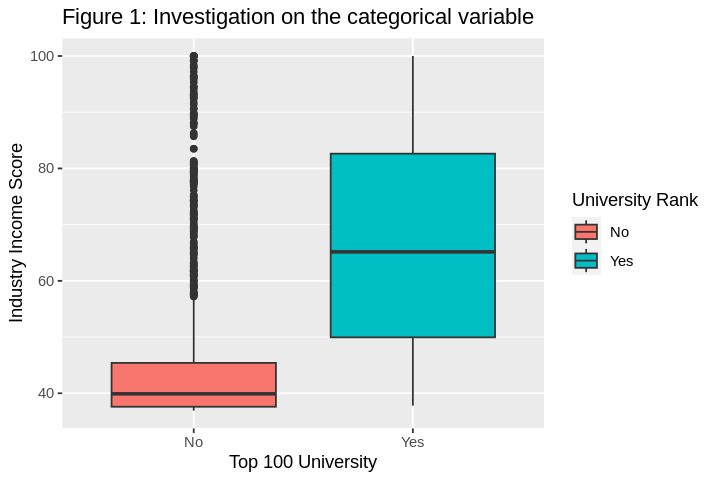

In [5]:
options(repr.plot.width = 6, repr.plot.height = 4)

ggplot(data) +
geom_boxplot(aes(x = as.factor(Top100), y = Industry.Income.Score, fill = as.factor(Top100))) +
labs(x = "Top 100 University", y = "Industry Income Score", fill = "University Rank") +
ggtitle("Figure 1: Investigation on the categorical variable") +
scale_fill_discrete(labels=c('No', 'Yes')) +
scale_x_discrete(labels=c('No', 'Yes'))

Figure 1 demonstrates the relationship between the industry income score and the rankings of a university. Ignoring the outliers, the top 100 universities have a median industry income score above 60, while that of the rest universities is only around 40. The industry income scores cluster around higher values for top 100 universities, suggesting a potential positive relationship between the rank group and the industry income score.

Warning message:
“Removed 36 rows containing missing values (`geom_text()`).”


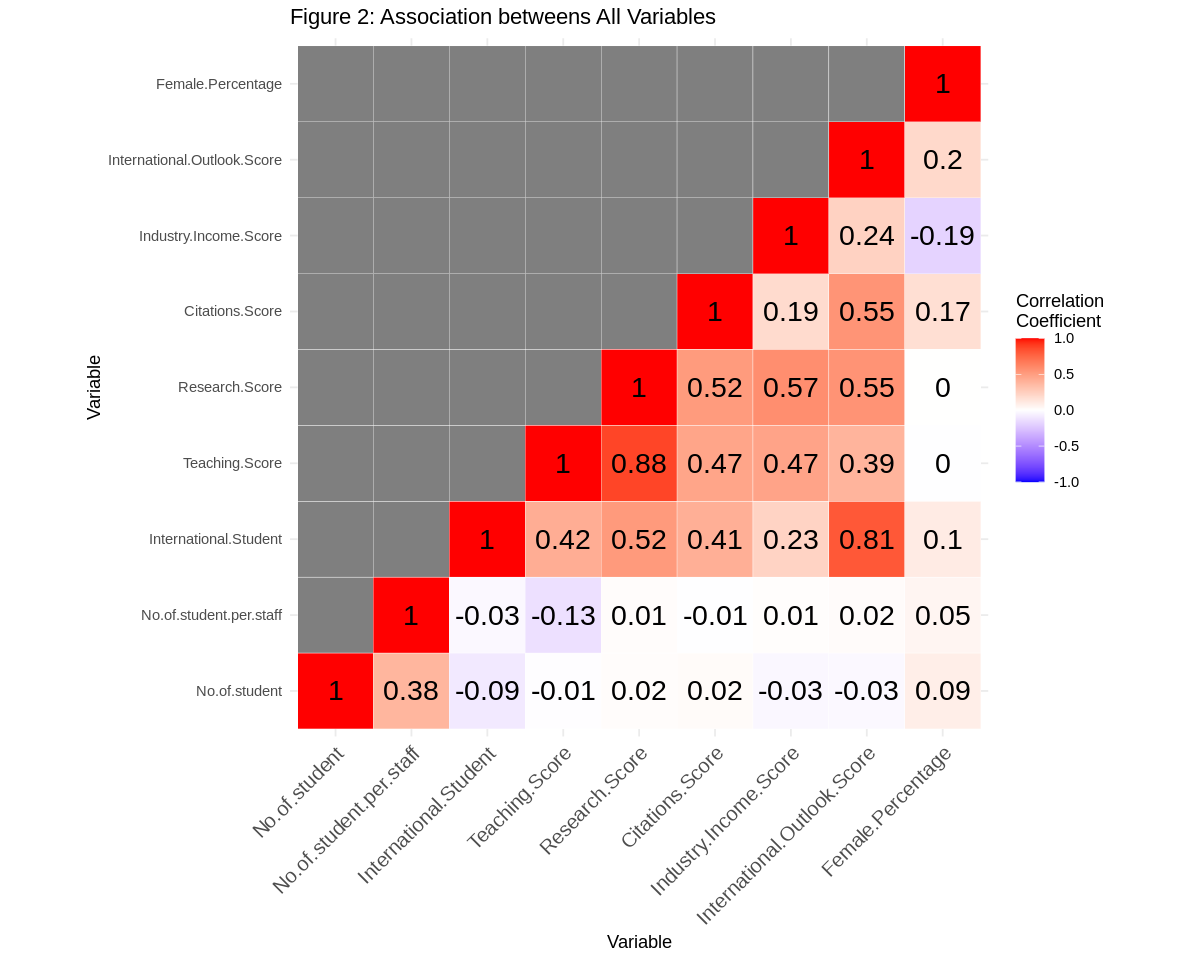

In [6]:
corr_matrix <- data |> 
    select(-c(Top100)) |>
    cor()

get_lower_tri <- function(corr_mat){
    corr_mat[upper.tri(corr_mat)] <- NA
    return(corr_mat)
  }

corr_mat <- get_lower_tri(corr_matrix) |> melt()

options(repr.plot.width = 10, repr.plot.height = 8)

ggplot(data = corr_mat, aes(Var1, Var2, fill = value))+
 geom_tile(color = "white")+
 scale_fill_gradient2(low = "blue", high = "red", mid = "white", 
   midpoint = 0, limit = c(-1,1), space = "Lab", 
   name="Correlation\nCoefficient") +
  theme_minimal()+ 
 theme(axis.text.x = element_text(angle = 45, vjust = 1, 
    size = 12, hjust = 1))+
  geom_text(aes(Var1, Var2, label = round(value, 2)), color = "black", size = 6) +
  labs(title = "Figure 2: Association betweens All Variables", x = "Variable", y = "Variable") +
 coord_fixed()

Figure 2 visualizes the association between the response variable and its eight numerical explanatory variables. The response variable `Industry.Income.Score` has a relatively strong association with `Research.Score` and `Teaching.Score`. In addition, a significant association between these two variables is also revealed, and this situation also occurs between some other explanatory variables (i.e., multicollinearity issue).

#### Summary Tables

In [7]:
cont_var <- data |> select(-Top100)

summary_stats_continuous <- gather(cont_var, factor_key = TRUE) |>
    group_by(key) |>
    summarise(mean= mean(value), sd= sd(value), max = max(value),min = min(value))

summary_stats_continuous[, 2:5] <- round(summary_stats_continuous[, 2:5], 2)
summary_stats_continuous

key,mean,sd,max,min
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
No.of.student,22853.13,27953.75,460632.0,489.0
No.of.student.per.staff,18.87,11.41,232.2,0.9
International.Student,10.63,12.38,91.0,0.0
Teaching.Score,26.68,12.89,94.8,11.6
Research.Score,22.69,16.44,99.7,7.4
Citations.Score,49.15,27.80,100.0,1.7
Industry.Income.Score,46.18,14.14,100.0,36.9
International.Outlook.Score,47.28,22.73,99.7,14.1
Female.Percentage,50.72,12.27,90.0,2.0


In [8]:
data |> 
    group_by(Top100) |> 
    summarize(n= n(),
              prop = n()/nrow(data),
              std.dev = sqrt(prop*(1-prop)/nrow(data))) |>
    mutate(prop = round(prop, 2),
          std.dev = round(std.dev, 2))


Top100,n,prop,std.dev
<dbl>,<int>,<dbl>,<dbl>
0,1532,0.95,0.01
1,88,0.05,0.01


### Methods: Plan

#### Overview
To predict the industry income score, we utilize the forward selection algorithm and ridge regression method on the training set, selecting the most optimal model. Subsequently, we assess the model's performance on the testing data based on the chosen model.

- Why is **forward selection algorithm** chosen?

The Forward Selection technique can simplify models and prevent overfitting by aiding in model simplification. It starts with no predictors and adds them one by one, choosing at each step the variable that has the most significant statistical contribution to the model.

- Why is **Ridge method** chosen?

From the EDA section, we suspect the presence of multicollinearity. While traditional linear regression can yield unstable and imprecise coefficient estimates, the introduction of a penalty term can shrink the coefficients, stabilizing the model and mitigating the issue of multicollinearity.

#### test/train split

Initially, we acquired a training set and a testing set by reserving 30% of the original dataset for testing purposes. It's important to note that we refrained from inspecting the testing set until after the model selection process is completed.

In [9]:
uni_split <- initial_split(data, prop = 0.7, strata = Industry.Income.Score)
train_set <- training(uni_split)
test_set <- testing(uni_split)

# Build matrix and vector required by `cv.glmnet`
X_train <- model.matrix(object = Industry.Income.Score ~ .,
  data = train_set)[, -1]

Y_train <- train_set[, "Industry.Income.Score"]

X_test <- model.matrix(object = Industry.Income.Score ~ .,
  data = test_set)[, -1]

Y_test <- test_set[, "Industry.Income.Score"]

#### Forward Selection

To estimate the predictive performance of the selected model, we utilized cross-validation with both forward selection and ridge regression. 

We started it with the forward selection.

Since there is no readily available package for performing this task, we adopted a relatively involved approach by coding from scratch.

Citation:
Codes are inspired from p273-274 of *Introduction to Statistical Learning* by James, Witten, Hastie and Tibshirani.

In [10]:
# create a vector that allocates each observation to one of k = 10 folds
k = 10
n <- nrow(train_set)
folds <- sample(rep(1:k, length = n))

# create a matrix to store the results
cv.errors <- matrix(NA, k, 9, dimnames = list(NULL, paste(1:9)))

In [11]:
# customize the predict function on regsubsets object
predict.regsubsets <- function(object, newdata , id, ...) {
    form <- as.formula(object$call[[2]])
    mat <- model.matrix(form, newdata)
    coefi <- coef(object, id = id)
    xvars <- names(coefi)
    mat[, xvars] %*% coefi
}

In [12]:
# For each fold
for(j in 1:k){
  # Fit the model with each subset of predictors on the training part of the fold
  best.fit=regsubsets(Industry.Income.Score~.,data=train_set[folds!=j,], method = "forward", nvmax=9) 
  # For each subset
  for(i in 1:9){
    # Predict on the hold out part of the fold for that subset
    pred=predict.regsubsets(best.fit, train_set[folds==j,],id=i)
    # Get the mean squared error for the model trained on the fold with the subset
    cv.errors[j,i]=mean((train_set$Industry.Income.Score[folds==j]-pred)^2)
  }
}

The resulting matrix has given us a 10×8 matrix, of which the $(j, i)$th element corresponds
to the test MSE for the $j$th cross-validation fold for the best $i$th-variable model.

In [13]:
head(cv.errors, 3)

1,2,3,4,5,6,7,8,9
113.9768,106.45444,107.18373,104.56551,101.98470,99.49086,99.15430,99.60304,100.12784
70.9411,63.17766,64.68517,61.59652,59.18132,60.14411,60.60824,60.75719,60.82149
107.8644,107.35463,106.76987,102.37422,100.65935,99.90838,100.24600,100.26126,100.29461


We then average over the columns of this matrix in order to obtain a vector for which the $i$th element is the cross-validation error for the $i$-variable model.

In [14]:
mean.cv.errors <- apply(cv.errors, 2, mean)
mean.cv.errors

# i-variable model that has the lowest mse
which.min(mean.cv.errors)

1        2        3        4        5        6        7        8 
126.5253 119.3854 121.4728 119.6957 118.8094 116.8562 116.6003 116.9750 
       9 
117.1072

7 
7

We see that cross-validation selects a 7-variable model. We can input the corresponding RMSE into a table `RMSE_models`.

In [15]:
RMSE_models <- tibble(
  Method = "Forward Selection",
  RMSE = min(mean.cv.errors)^0.5
)
RMSE_models

Method,RMSE
<chr>,<dbl>
Forward Selection,10.79816


#### Ridge Regression

Next, we train the ridge regression model using the same training set employed for forward selection.

In [16]:
# Use cross-validation to tune the parameter and fit the ridge model
cv_lambda_ridge <- cv.glmnet(
  x = X_train, y = Y_train,
  alpha = 0,
  lambda = exp(seq(-5, 10, 0.1)) 
    #standardize = TRUE : the default setting that helps standardize the predictors
)

In [17]:
# summarize results
print(cv_lambda_ridge)


Call:  cv.glmnet(x = X_train, y = Y_train, lambda = exp(seq(-5, 10,      0.1)), alpha = 0) 

Measure: Mean-Squared Error 

    Lambda Index Measure    SE Nonzero
min  0.030   136   116.7 12.11       9
1se  7.389    81   128.4 12.56       9


Observing that the model achieves optimal performance with a lambda value of 0.027 (lowest MSE), we incorporate the RMSE from the cross-validation ridge model into the summary table for comparison with the forward selection method.

In [18]:
RMSE_models <- RMSE_models |>
    rbind(c("Ridge", min(cv_lambda_ridge$cvm)^0.5))

RMSE_models

Method,RMSE
<chr>,<chr>
Forward Selection,10.7981625446802
Ridge,10.8020999729559


Employing RMSE as the metric for model performance assessment, we observe a slightly superior performance with the forward selection method in prediction. Consequently, we will proceed with utilizing forward selection for variable selection and fitting the multiple linear regression model on the testing set to evaluate overall performance.

#### Model Construction

As cross-validation with forward selection has chosen all 7 variables, we now perform best subset selection on the full data set in order to obtain the 7-variable model. We will then use these predictors build a linear regression model, and summarize the fitting details.

In [19]:
reg.best <- regsubsets(Industry.Income.Score ~ ., data = train_set, nvmax = 9)

selected_var <- names(coef(reg.best, 7))[-1]

training_subset <- train_set %>% select(all_of(selected_var), Industry.Income.Score)

red_OLS <- lm(Industry.Income.Score ~ ., data = training_subset)
summary(red_OLS)


Call:
lm(formula = Industry.Income.Score ~ ., data = training_subset)

Residuals:
    Min      1Q  Median      3Q     Max 
-33.855  -5.553  -1.792   2.563  52.438 

Coefficients:
                        Estimate Std. Error t value Pr(>|t|)    
(Intercept)            4.627e+01  1.651e+00  28.022  < 2e-16 ***
No.of.student         -1.731e-05  1.052e-05  -1.646 0.100035    
International.Student -1.102e-01  3.238e-02  -3.404 0.000686 ***
Teaching.Score        -1.325e-01  5.322e-02  -2.490 0.012907 *  
Research.Score         7.366e-01  4.752e-02  15.501  < 2e-16 ***
Citations.Score       -3.833e-02  1.411e-02  -2.716 0.006699 ** 
Female.Percentage     -1.899e-01  2.717e-02  -6.990 4.69e-12 ***
Top100                -6.847e+00  2.143e+00  -3.196 0.001434 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 10.71 on 1125 degrees of freedom
Multiple R-squared:  0.4241,	Adjusted R-squared:  0.4205 
F-statistic: 118.3 on 7 and 1125 DF,  p-value: < 2.

Within this model, all the p-values fall below .05 except for `No.of.student`, which shows that effects of most explanatory variables on the response variable are statistically significant.

The $R^2$ is 0.4241, which means that 42.4% of the variation in industry score is explained by this model, which indicates a relatively poor fit of our model.

#### Model Evaluation

This next section focuses on evaluating the performance of the linear regression model on test dataset as well as visualizing this relationship. 

First we generate prediction scores in the model, and then calculate the RMSE to measure the error of the models prediction (which is 11.913, which means the predicted values are around 11.913 units away from the actual values).

Lastly we visualized this with a scatter plot that represents how well the predicted values align with the actual values.

In [20]:
test_pred_red_OLS <- predict(red_OLS, newdata = test_set)

rmse_val <- sqrt(mean((test_pred_red_OLS - test_set$Industry.Income.Score)^2))

RMSE_models <- RMSE_models |>
    rbind(c("Forward Selection (test)",rmse_val))

RMSE_models

Method,RMSE
<chr>,<chr>
Forward Selection,10.7981625446802
Ridge,10.8020999729559
Forward Selection (test),11.9132354955795


Upon comparing the first and third rows, it's noticeable that the `RMSE` on the testing set is only slightly larger than that from the training set. Consequently, the concern regarding overfitting appears to be minor.

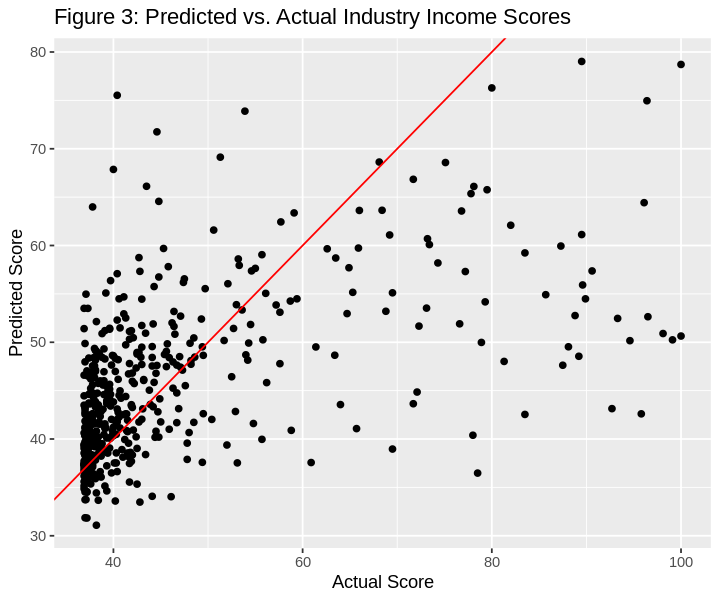

In [21]:
options(repr.plot.width=6, repr.plot.height=5)

ggplot(data = test_set, aes(x = Industry.Income.Score, y = test_pred_red_OLS)) + 
    geom_point() + 
    geom_abline(slope = 1, intercept = 0, color = "red") +
    labs(title = "Figure 3: Predicted vs. Actual Industry Income Scores", x = "Actual Score", y = "Predicted Score")

Based on Figure 3, the data points distribution shows a non-linear relation between the predicted and actual industry income scores. The plot demonstrates a remarkable and unexpected phenomenon that most actual scores above 60 are incorrectly predicted to be lower. For the other actual scores, the wide-spread distribution of their predicted values also indicates a low accuracy. Due to the inaccurate prediction of most industry income scores, this model with the chosen prediction variables seems to be inefficient.

## 3. Discussion


## 4. References